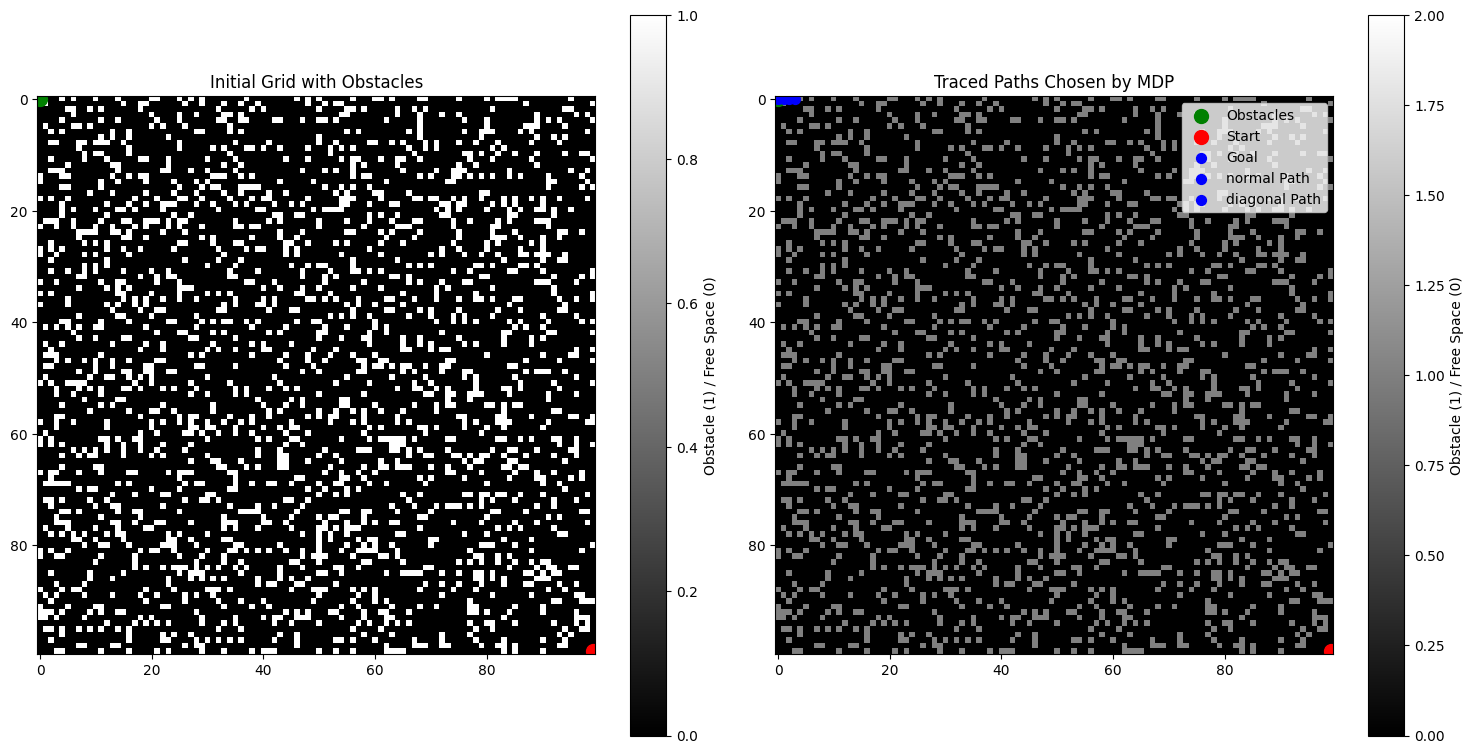

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 100
OBSTACLE_PROBABILITY = 0.2
DISCOUNT_FACTOR = 0.9
NUM_EPISODES = 1000

# Directions
normal_directions = [(0, 1), (1, 0), (0, -1), (-1, 0)] 
diagonal_directions = [(1, 1), (1, -1), (-1, -1), (-1, 1)]

# Generate grid with random obstacles
def generate_grid(size):
    grid = np.random.choice([0, 1], size=(size, size), p=[1 - OBSTACLE_PROBABILITY, OBSTACLE_PROBABILITY])
    return grid

def policy_evaluation(grid, policy):
    v_pi = np.zeros((GRID_SIZE, GRID_SIZE))
    
    for _ in range(NUM_EPISODES):
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if grid[x][y] == 1:
                    continue
                
                action_values = []
                for action in policy:
                    next_pos = (x + action[0], y + action[1])
                    if (0 <= next_pos[0] < GRID_SIZE) and (0 <= next_pos[1] < GRID_SIZE) and (grid[next_pos] == 0):
                        reward = -1 
                        action_values.append(reward + DISCOUNT_FACTOR * v_pi[next_pos])
                    else:
                        reward = -1
                        action_values.append(reward)
                
                v_pi[x][y] = np.mean(action_values)
    
    return v_pi

def compute_action_value_function(grid, v_pi):
    q_pi = np.zeros((GRID_SIZE, GRID_SIZE, len(normal_directions) + len(diagonal_directions)))
    
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x][y] == 1:
                continue
            
            for idx, action in enumerate(normal_directions + diagonal_directions):
                next_pos = (x + action[0], y + action[1])
                if (0 <= next_pos[0] < GRID_SIZE) and (0 <= next_pos[1] < GRID_SIZE) and (grid[next_pos] == 0):
                    reward = -1
                    q_pi[x][y][idx] = reward + DISCOUNT_FACTOR * v_pi[next_pos]
                else:
                    reward = -1
                    q_pi[x][y][idx] = reward
    
    return q_pi

def find_best_policy(q_pi_normal, q_pi_diagonal):
    best_policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if q_pi_normal[x][y].sum() > 0 or q_pi_diagonal[x][y].sum() > 0:
                combined_q_values = np.concatenate((q_pi_normal[x][y], q_pi_diagonal[x][y]))
                best_action_index = np.argmax(combined_q_values)
                best_policy[x][y] = best_action_index
    
    return best_policy

def trace_back_path(best_policy_indices, start_position, goal_position):
    path_normal = []
    path_diagonal = []
    current_position = start_position
    
    while current_position != goal_position:
        x, y = current_position
        
        best_action_index = best_policy_indices[x][y]
        
        if best_action_index < len(normal_directions): 
            action = normal_directions[best_action_index]
            next_position = (x + action[0], y + action[1])
            path_normal.append(current_position)
        else:
            action = diagonal_directions[best_action_index - len(normal_directions)]
            next_position = (x + action[0], y + action[1])
            path_diagonal.append(current_position)

        if not (0 <= next_position[0] < GRID_SIZE) or not (0 <= next_position[1] < GRID_SIZE) or grid[next_position] == 1:
            break
        
        current_position = next_position
    
    if current_position == goal_position:
        path_normal.append(goal_position)
        path_diagonal.append(goal_position)
    
    return path_normal, path_diagonal

grid = generate_grid(GRID_SIZE)

normal_policy = normal_directions
diagonal_policy = diagonal_directions

v_pi_normal = policy_evaluation(grid, normal_policy)
q_pi_normal = compute_action_value_function(grid, v_pi_normal)

v_pi_diagonal = policy_evaluation(grid, diagonal_policy)
q_pi_diagonal = compute_action_value_function(grid, v_pi_diagonal)

best_policy_indices = find_best_policy(q_pi_normal, q_pi_diagonal)

start_position = (0, 0)
goal_position = (GRID_SIZE - 1, GRID_SIZE - 1)

optimal_path_normal, optimal_path_diagonal = trace_back_path(best_policy_indices, start_position, goal_position)


## GPT CODE FOR PLOTTING GRID AND RESULT

# Display initial grid with start and goal positions marked
plt.figure(figsize=(15, 15))  # Increased figure size for better visibility

plt.subplot(2, 2, 1)
plt.imshow(grid, cmap='gray')
plt.title('Initial Grid with Obstacles')
plt.colorbar(label='Obstacle (1) / Free Space (0)')
plt.scatter(*start_position[::-1], color='green', label='Start', s=100)
plt.scatter(*goal_position[::-1], color='red', label='Goal', s=100)

# Display final grid with optimal actions indicated by colors and paths traced back
final_grid_with_best_policy_and_path = np.copy(grid)

# Marking the traced paths with different colors based on which policy was chosen.
for pos in optimal_path_normal:
    final_grid_with_best_policy_and_path[pos] = 2   # normal path marked as '2'
for pos in optimal_path_diagonal:
    final_grid_with_best_policy_and_path[pos] = 3   # diagonal path marked as '3'

plt.subplot(2, 2, 2)
plt.imshow(final_grid_with_best_policy_and_path.astype(float), cmap='gray')
plt.title('Traced Paths Chosen by MDP')
plt.colorbar(label='Obstacle (1) / Free Space (0)')
plt.scatter(*start_position[::-1], color='green', label='Start', s=100)
plt.scatter(*goal_position[::-1], color='red', label='Goal', s=100)

# Overlaying paths with distinct colors on top of the grid visualization.
for pos in optimal_path_normal:
    plt.scatter(pos[1], pos[0], color='blue', s=50)   # normal path in blue

for pos in optimal_path_diagonal:
    plt.scatter(pos[1], pos[0], color='orange', s=50)   # diagonal path in orange

plt.legend(['Obstacles', 'Start', 'Goal', 'normal Path', 'diagonal Path'])

plt.tight_layout()
plt.show()